Documentação da Análise Exploratória da base de dados de propriedades do Oleo 
Extraído de dados Publicos (artigos e bancos de dados)

## Imports

In [1]:
# Importação de bibliotecas 
from platform import python_version

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import graphviz

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score,max_error, mean_absolute_error, mean_squared_error
import statistics as st 

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

#TRANFORMA KERA MODEL EM SCIKIT LEARN MODEL (Implementation of the scikit-learn classifier API for Keras)
from keras.wrappers.scikit_learn import KerasRegressor

#To Save models
import pickle
from keras.models import save

In [2]:
print(f'Python Version {python_version()}')
print(f'Pandas Version {pd.__version__}')
print(f'Tensor Flow Version {tf.__version__}')

Python Version 3.8.8
Pandas Version 1.2.4
Tensor Flow Version 2.7.0


## Functions

In [3]:
def statistcs(y_test, Resultado):
    
    Resultados_Estatisticos = []
    
    MAE = round(mean_absolute_error(y_test, Resultado),2)
    MAPE_var = round(MAPE(y_test, Resultado)*100,2)
    RMSE = round(mean_squared_error(y_test, Resultado)**0.5,2)
    MAX_ERROR = round(max_error(y_test, Resultado),2)
    R2_test = round(r2_score(y_test, Resultado),4)
    
    y_test = np.array(y_test, dtype='f')
    prediction_error = abs(y_test.flatten() - Resultado.flatten())
    
    Stdev_abs = round(st.stdev(prediction_error),2)
    Stdev_rel = round(st.stdev(prediction_error/st.mean(prediction_error)),2) 
    
    Resultados_Estatisticos.append([MAE, MAPE_var, RMSE, Stdev_abs, Stdev_rel, MAX_ERROR, R2_test])
    
    Error_matrix = pd.DataFrame(data = Resultados_Estatisticos, columns = ['MAE','MAPE_(%)','RMSE','SDa', 'SDr','Emax','R2'])
    
    return Error_matrix

## Dataset Creation

In [4]:
# Criação de DATASET 
df = pd.read_csv('PB-DATASET-API.csv', sep =',', decimal = '.' )


df['OilGrav'] = round((141.5/(df['API']+131.5)),3)
display(df)

properties = df.columns
print(properties)

,PB,RS,GG,API,TEMP,OilGrav
0,4509,1409,0.799,42.5,260,0.813
1,3516,950,0.980,31.7,230,0.867
2,3811,909,0.732,38.0,180,0.835
3,4750,1280,0.756,38.6,180,0.832
4,4026,1052,0.767,37.4,193,0.838
...,...,...,...,...,...,...
722,2692,393,0.631,38.6,179,0.832
723,3420,1212,0.685,42.3,194,0.814
724,3160,1213,0.705,45.4,186,0.800
725,3063,586,0.628,32.2,180,0.864


Index(['PB', 'RS', 'GG', 'API', 'TEMP', 'OilGrav'], dtype='object')


In [5]:
df['Type'] = 'Medium'

filtro = df.API >= 32
df['Type'].loc[filtro] = 'Light'

#filtro = df.API < 32 and df.API > 23
#df['Type'].loc[filtro] = 'Medium'

filtro = df.API <= 23
df['Type'].loc[filtro] = 'Heavy'

df.groupby('Type').count()

C:\Users\danie\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\danie\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,PB,RS,GG,API,TEMP,OilGrav
Type,,,,,,
Heavy,68,68,68,68,68,68
Light,506,506,506,506,506,506
Medium,153,153,153,153,153,153


In [6]:
#verificação se há dados faltantes
#e obter informações dos dados presentes

print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727 entries, 0 to 726
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   PB       727 non-null    int64  
 1   RS       727 non-null    int64  
 2   GG       727 non-null    float64
 3   API      727 non-null    float64
 4   TEMP     727 non-null    int64  
 5   OilGrav  727 non-null    float64
 6   Type     727 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 39.9+ KB
None


,PB,RS,GG,API,TEMP,OilGrav
count,727.000000,727.000000,727.000000,727.000000,727.000000,727.000000
mean,2003.755158,633.861073,1.137160,34.927235,196.405777,0.852585
std,1441.172613,506.565126,0.434983,8.500812,53.221577,0.046343
min,79.000000,9.000000,0.521000,6.000000,74.000000,0.751000
25%,815.000000,267.000000,0.815000,30.800000,160.000000,0.825000
50%,1755.000000,514.000000,1.000000,37.400000,194.000000,0.838000
75%,2900.500000,833.500000,1.316500,40.000000,238.000000,0.872000
max,7142.000000,3299.000000,3.445000,56.800000,342.000000,1.029000


In [7]:
df.drop(['Type'], axis = 1)

columns = df.drop(['Type'], axis = 1).columns

columns

Index(['PB', 'RS', 'GG', 'API', 'TEMP', 'OilGrav'], dtype='object')

In [8]:
minmax = []
columns = df.drop(['Type'], axis = 1).columns
for coluna in columns:
    minmax.append([df[coluna].min(), df[coluna].max()])

df_norm = (df[columns]-df[columns].min())/(df[columns].max()-df[columns].min())
display(df_norm)

dfminmax = pd.DataFrame(minmax, columns = ['Min', 'Max'], index = ['PB','RS','GG','API','Temp','OilGrav'])
dfminmax = dfminmax.T
display (dfminmax)

,PB,RS,GG,API,TEMP,OilGrav
0,0.627212,0.425532,0.095075,0.718504,0.694030,0.223022
1,0.486620,0.286018,0.156977,0.505906,0.582090,0.417266
2,0.528387,0.273556,0.072161,0.629921,0.395522,0.302158
3,0.661334,0.386322,0.080369,0.641732,0.395522,0.291367
4,0.558828,0.317021,0.084131,0.618110,0.444030,0.312950
...,...,...,...,...,...,...
722,0.369956,0.116717,0.037620,0.641732,0.391791,0.291367
723,0.473028,0.365653,0.056088,0.714567,0.447761,0.226619
724,0.436217,0.365957,0.062927,0.775591,0.417910,0.176259
725,0.422483,0.175380,0.036594,0.515748,0.395522,0.406475


,PB,RS,GG,API,Temp,OilGrav
Min,79.0,9.0,0.521,6.0,74.0,0.751
Max,7142.0,3299.0,3.445,56.8,342.0,1.029


### Empirical Correlations

In [9]:
#df2 = pd.DataFrame()

df['Standing'] = round(18.2*(((df['RS']/df['GG'])**0.83)*10**((0.00091*df['TEMP'])-0.0125*df['API'])-1.4),2)

g = pd.DataFrame(df).to_numpy()
VasquezBeggs = []
glaso = []
gamags = []
A = []
x = []
PetroskiFarshad = []

for item in range(len(g)):
  if g[item][3] > 30:
    c1, c2, c3 = 56.18, 0.84246, -10.393
  else:
    c1, c2, c3 = 27.624, 0.914328, -11.172
  
  gamags.append(g[item][2]*(1+0.00005912*g[item][3]*60*math.log(164.7/114.7,10)))
  VasquezBeggs.append(round((c1*(g[item][1]/gamags[item])*10**(c3*(g[item][3]/(g[item][4]+460))))**c2,2))

  A.append(math.log(((g[item][1]/g[item][2])**0.816)*g[item][4]**0.173/g[item][3]**0.989,10))
  glaso.append(round(10**(1.7669+1.7447*A[item]-0.30218*(A[item]**2)),2))

df['Vasquez-Beggs'] = VasquezBeggs
df['Glaso'] = glaso
df['Al-Marhoun'] = round(0.00538088*(df['RS']**0.715082)*(df['GG']**(-1.87784))*(df['OilGrav']**3.1437)*((df['TEMP']+460)**1.32657),2)
df['Petroski-Farshad'] = round(112.727*(df['RS']**0.577421)/((df['GG']**0.8439)*10**(0.0007916*df['API']**1.541-0.000045618*(df['TEMP']**1.3911)))-1391.051,2)


display(df)


,PB,RS,GG,API,TEMP,OilGrav,Type,Standing,Vasquez-Beggs,Glaso,Al-Marhoun,Petroski-Farshad
0,4509,1409,0.799,42.5,260,0.813,Light,4544.39,4824.92,4643.88,4713.98,4934.83
1,3516,950,0.980,31.7,230,0.867,Medium,3538.33,3813.25,3816.93,2803.68,3667.77
2,3811,909,0.732,38.0,180,0.835,Light,3262.55,3572.98,3748.39,3778.29,3881.62
3,4750,1280,0.756,38.6,180,0.832,Light,4154.58,4551.22,4637.32,4491.23,4785.97
4,4026,1052,0.767,37.4,193,0.838,Light,3707.83,4054.27,4140.29,3990.80,4273.19
...,...,...,...,...,...,...,...,...,...,...,...,...
722,2692,393,0.631,38.6,179,0.832,Light,1793.31,1956.14,2095.59,2704.92,2243.28
723,3420,1212,0.685,42.3,194,0.814,Light,3988.22,4317.88,4472.26,4994.00,4728.26
724,3160,1213,0.705,45.4,186,0.800,Light,3501.79,3761.80,4091.66,4410.19,4144.63
725,3063,586,0.628,32.2,180,0.864,Light,3039.45,3380.48,3512.53,4097.69,3815.93


,MAE,MAPE_(%),RMSE,SDa,SDr,Emax,R2


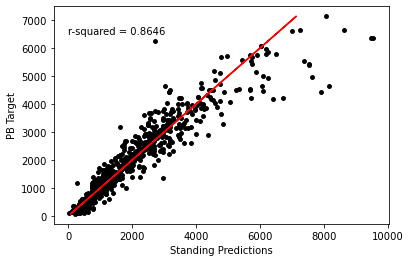

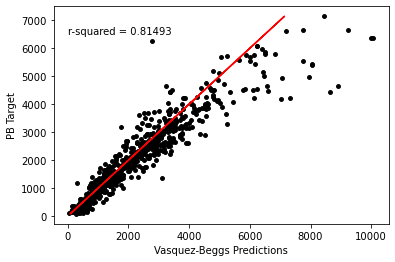

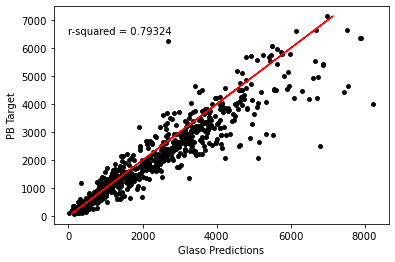

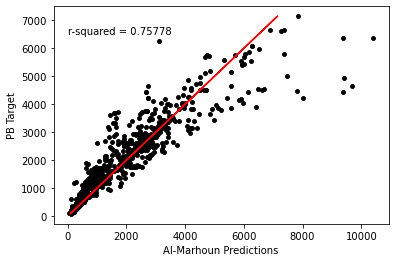

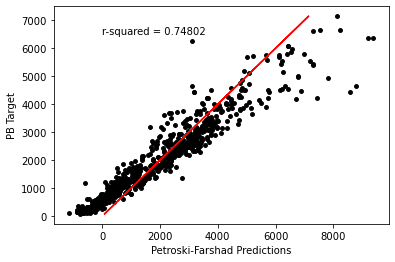

In [10]:
correlations = ['Standing', 'Vasquez-Beggs', 'Glaso', 'Al-Marhoun','Petroski-Farshad']

Error_Results = pd.DataFrame(columns = ['MAE','MAPE_(%)','RMSE','SDa', 'SDr','Emax','R2'])
display(Error_Results)

for coluna in correlations:
    plt.scatter(df[coluna], df['PB'], color = 'k', marker = 'o', s = 15)
    plt.xlabel(coluna + ' Predictions')
    plt.ylabel('PB Target')
    plt.plot(df['PB'], df['PB'], color = 'r')
    r2 = round(r2_score(df['PB'],df[coluna]),5)
    plt.annotate(f'r-squared = {r2}', (0,6500))
    plt.show()

## Data Vizualization

In [11]:
#!pip install  plotly

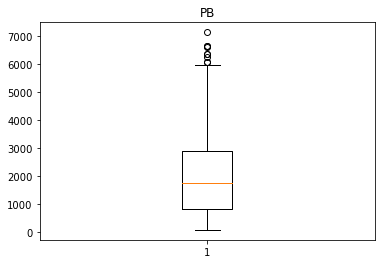

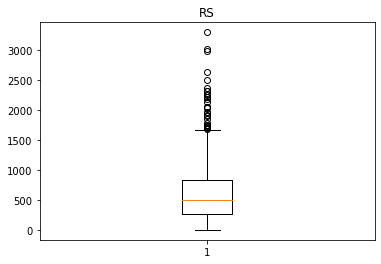

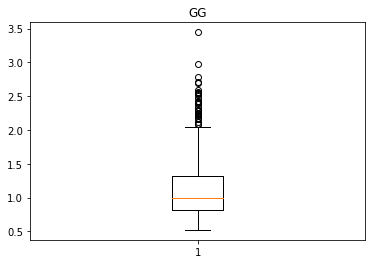

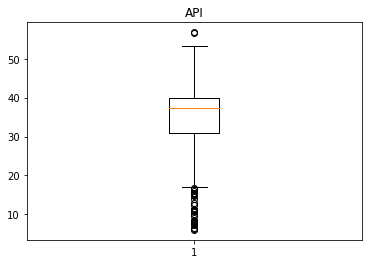

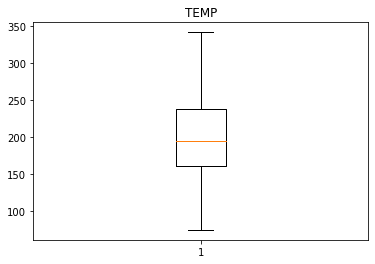

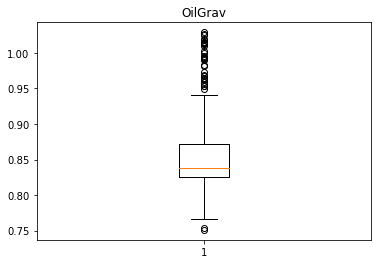

In [12]:
for coluna in properties:
    plt.boxplot(df[coluna])
    plt.title(coluna)
    plt.show()

Nos gráficos acima é possível verificar a existência de outilers. 

No entanto estes não foram removidos devido ao fato do conjunto de dados ser de poços de localidades e características diferentes.

Caso fosse optado pela remoção deste, tal ação poderia ser realziada por meio da técnica do z-score, que remove valores fora do range média ± desvio padrão da propriedade.

Esta remoção poderia ocasionar em uma perda da representatividade do conjunto de amostras.

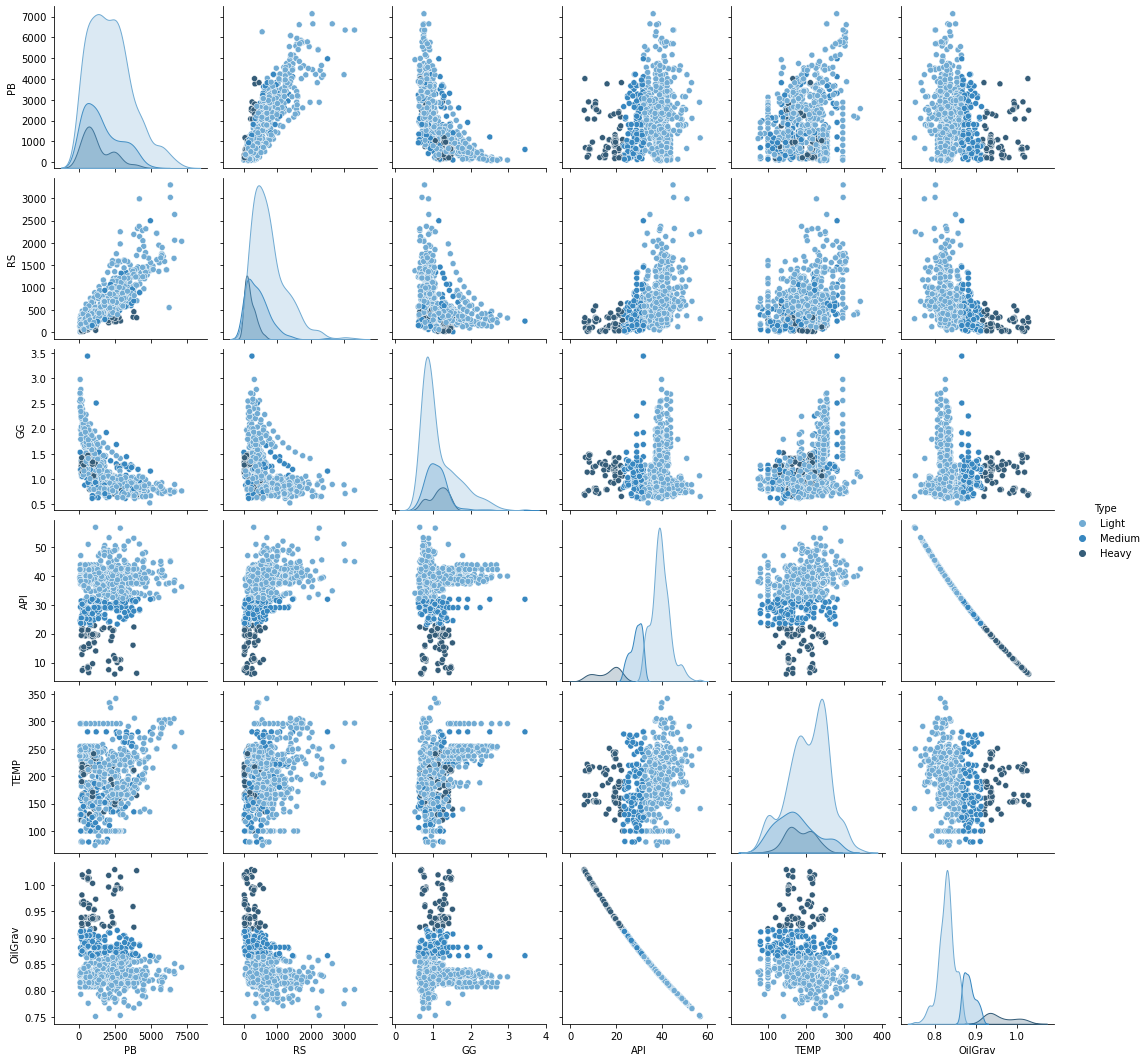

In [13]:
#!pip install seaborn

sns.pairplot(df.iloc[:,0:7], hue = 'Type', palette = 'Blues_d')

<AxesSubplot:>

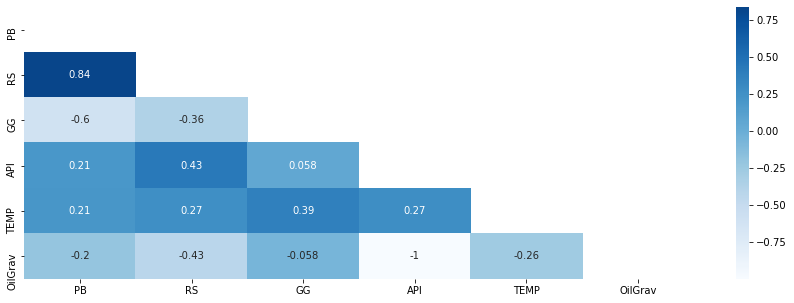

In [14]:
plt.figure(figsize=(15,5))

corr = df.iloc[:,0:6].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, annot=True, cmap="Blues", center = 0, mask = mask) #annot mostra os coeficientes da matriz

Podemos verificar a grande correlação da Razão de Gás Óleo (RS) com a Pressão de Bolha
Isto porque o RS também é um propriedade determinável pela Temperatura, dendidade específica do gás e do óleo, ou seja, RS = f(T, P, GasGrav, OilGrav).

O ideal seria criação de modelos preditivos de para todas as propriedades termodinâmicas e físico químicas e compará-las com as
correlações empíricas Standing, Vasquez-Beggs, Al-Marhoun, Petrosky-Farshad e etc...
No entando os procedimentos seriam semelhantes. 

Apesas da possibildiade de enfatizar a melhoria na preção por modelos criados por machine learning, este não será realizado.

No trabalho de conclusão de curso intitulado 

"MODELAGEM DE PROPRIEDADES FÍSICO QUÍMICAS E TERMODINÂMICAS DO ÓLEO E GÁS UTILIZANDO INTELIGÊNCIA ARTIFICIAL"

abordei a predição utilizando algumas ténicas presentes no ramo de machine learning para predição de Pb e Bo
e ainda comparei os resultados obtidos com os Softwares Python (Open Source) e Statistica®, produzido pela Tibco utilizando licença estudante e versão trial

#Dataset Split Test

In [15]:
#X = df.iloc[:, 1:5].values
#y = df.iloc[:, 0].values

#correlations_values = df2.values

X = df.iloc[:,1:]
#X.drop('API', axis = 1, inplace = True)
X.drop('OilGrav', axis = 1, inplace = True)

y = df.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

X_train_data, X_test_data, Correlations_test = X_train.iloc[:,0:4], X_test.iloc[:,0:4], X_test.iloc[:,5::] 

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)


### Motivation

Nas figura acima são demostradas o grau de dispersão dos valores predito pelas correlações empíricas em relação
aos valores verdadeiros de pressão de bolha determinados por métodos experimentais

Observa-se que as correlações apresentam grandes dispersões na determinição de valores altos de Pressão de Bolha, evidenciando as limitações das correlações empíricas hoje amplamente utilizadas. 

Por este e por outros motivos, a utilização do aprendizado de máquina (AM) surge como alternativa para geração de modelos que melhor se adaptam aos dados que se possuem. Nos modelos gerados por AM são métricas de eficiência do poder de predição e quanto ao poder de generalização. 

Modelos superajustados (overffiting) e sobreajustados (underfitting) não são desejáveis, com isso são variados parâmetros com o objetivo de se obter um modelo genalizado capaz de prover saídas confiáveis à dados não utilizados no treinamento do mesmo.



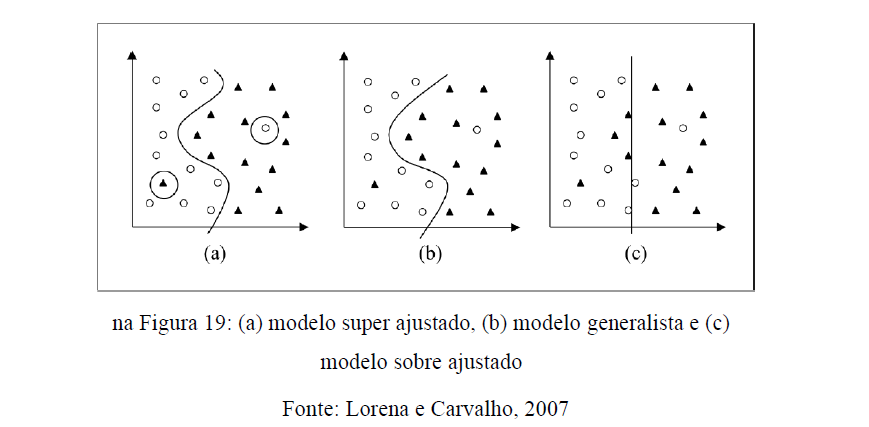

A proposta do trabalho foi gerar diferentes modelos de predição utilizando o aprendizado de máquinas, selecionando os hiperparâmetros que possibilitam a obtenção de valores da propriedade em questão com menor erro associado. 

Para quantificação dos resultados foi utilizada uma espécies de raqnueamento por Ikiensikimama e Azubuike, 2012, no qual é realizado um somatório da multiplicação dos pesos atribuídos a diferentes avaliadores estatíticos com as respectivas méticas de erros medidas, como é mostrado abaixo:




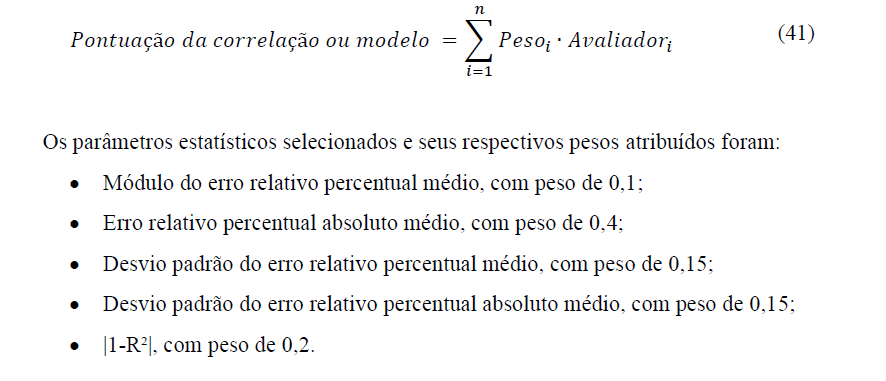


### Correlations 

In [16]:
for coluna in Correlations_test.columns:
    Error_Results = pd.concat([Error_Results, statistcs(y_test, np.array(Correlations_test[coluna]))])
    
Error_Results.index = correlations

display(Error_Results)

,MAE,MAPE_(%),RMSE,SDa,SDr,Emax,R2
Standing,320.36,24.31,566.04,467.63,1.46,3549.07,0.8511
Vasquez-Beggs,373.12,28.19,655.57,540.16,1.45,4230.90,0.8002
Glaso,405.17,25.72,608.28,454.64,1.12,3580.01,0.8280
Al-Marhoun,426.71,21.68,734.84,599.50,1.40,4943.84,0.7490
Petroski-Farshad,559.36,78.19,734.31,476.73,0.85,4151.92,0.7494


### Árvores de Decisão

In [17]:
dt = DecisionTreeRegressor()

display(dt.get_params())

max_depth = list(np.arange(2,21,2))

min_samples_leaf = list(np.arange(2,15,2))

min_samples_split = list(np.arange(2,30,2))
      
# Defining params_dt   
params_dt = {'max_depth': max_depth, 'min_samples_leaf':min_samples_leaf,'min_samples_split': min_samples_split}

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [18]:
# Instantiate grid_dt
grid_dt = GridSearchCV(estimator=dt,
                       param_grid=params_dt,
                       scoring='r2',
                       cv=10,
                       n_jobs=-1)

grid_dt.fit(X_train_data, y_train)

best_model_DT = grid_dt.best_estimator_

print(f'Best Paramns: {grid_dt.best_params_}')

#Saving the model
filename = 'DecicionTree_model.sav'
pickle.dump(best_model_DT, open(filename, 'wb'))

#for load
#loaded_best_model = pickle.load(open(filename, 'rb'))
#result = loaded_best_model.score(X_test, Y_test)
#print(result)

Best Paramns: {'max_depth': 8, 'min_samples_leaf': 12, 'min_samples_split': 2}


In [19]:
Treinamento = best_model_DT.predict(X_train_data)
Resultado = best_model_DT.predict(X_test_data)

R2_treinamento = round(r2_score(y_train, Treinamento),4)
R2_test = round(r2_score(y_test, Resultado),4)

print(f' R2_Train = {R2_treinamento}')
print(f' R2_test = {R2_test}')    

Error_Results = pd.concat([Error_Results, statistcs(y_test, Resultado)])

display(Error_Results)

 R2_Train = 0.9008
 R2_test = 0.8455


,MAE,MAPE_(%),RMSE,SDa,SDr,Emax,R2
Standing,320.36,24.31,566.04,467.63,1.46,3549.07,0.8511
Vasquez-Beggs,373.12,28.19,655.57,540.16,1.45,4230.90,0.8002
Glaso,405.17,25.72,608.28,454.64,1.12,3580.01,0.8280
Al-Marhoun,426.71,21.68,734.84,599.50,1.40,4943.84,0.7490
Petroski-Farshad,559.36,78.19,734.31,476.73,0.85,4151.92,0.7494
0,367.46,27.87,576.54,445.19,1.21,4130.56,0.8455


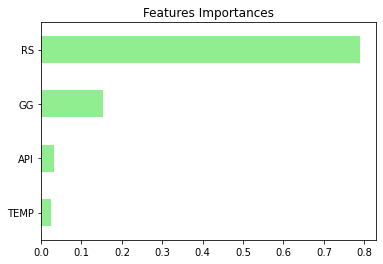

In [20]:
# A pd.Series of features importances
importances = pd.Series(data=best_model_DT.feature_importances_,
                        index= X_train_data.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

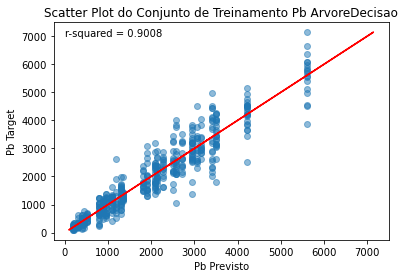

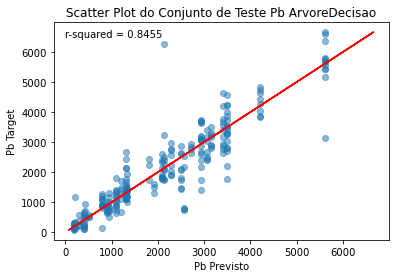

In [21]:
plt.scatter(Treinamento, y_train, alpha=0.5)
plt.plot(y_train, y_train, color = 'red')
plt.title('Scatter Plot do Conjunto de Treinamento Pb ArvoreDecisao')
plt.ylabel('Pb Target')
plt.xlabel('Pb Previsto')
plt.annotate(f'r-squared = {R2_treinamento}', (0,7000))
plt.show()

plt.scatter(Resultado, y_test, alpha=0.5)
plt.plot(y_test,y_test, color = 'red')
plt.title('Scatter Plot do Conjunto de Teste Pb ArvoreDecisao')
plt.ylabel('Pb Target')
plt.xlabel('Pb Previsto')
plt.annotate(f'r-squared = {R2_test}', (0,6500))
plt.show()

#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)

#tree.plot_tree(best_model_DT,
               feature_names = ['RS','GG','API','Temp', 'Oil Grav'],
               filled = True);


#fig.savefig('DT_BEST_MODEL.png')

tree.export_graphviz(best_model_DT,
                     out_file="tree.dot",
                     feature_names = ['RS','GG','API','Temp', 'Oil Grav'], 
                     leaves_parallel=False,
                     filled = True)

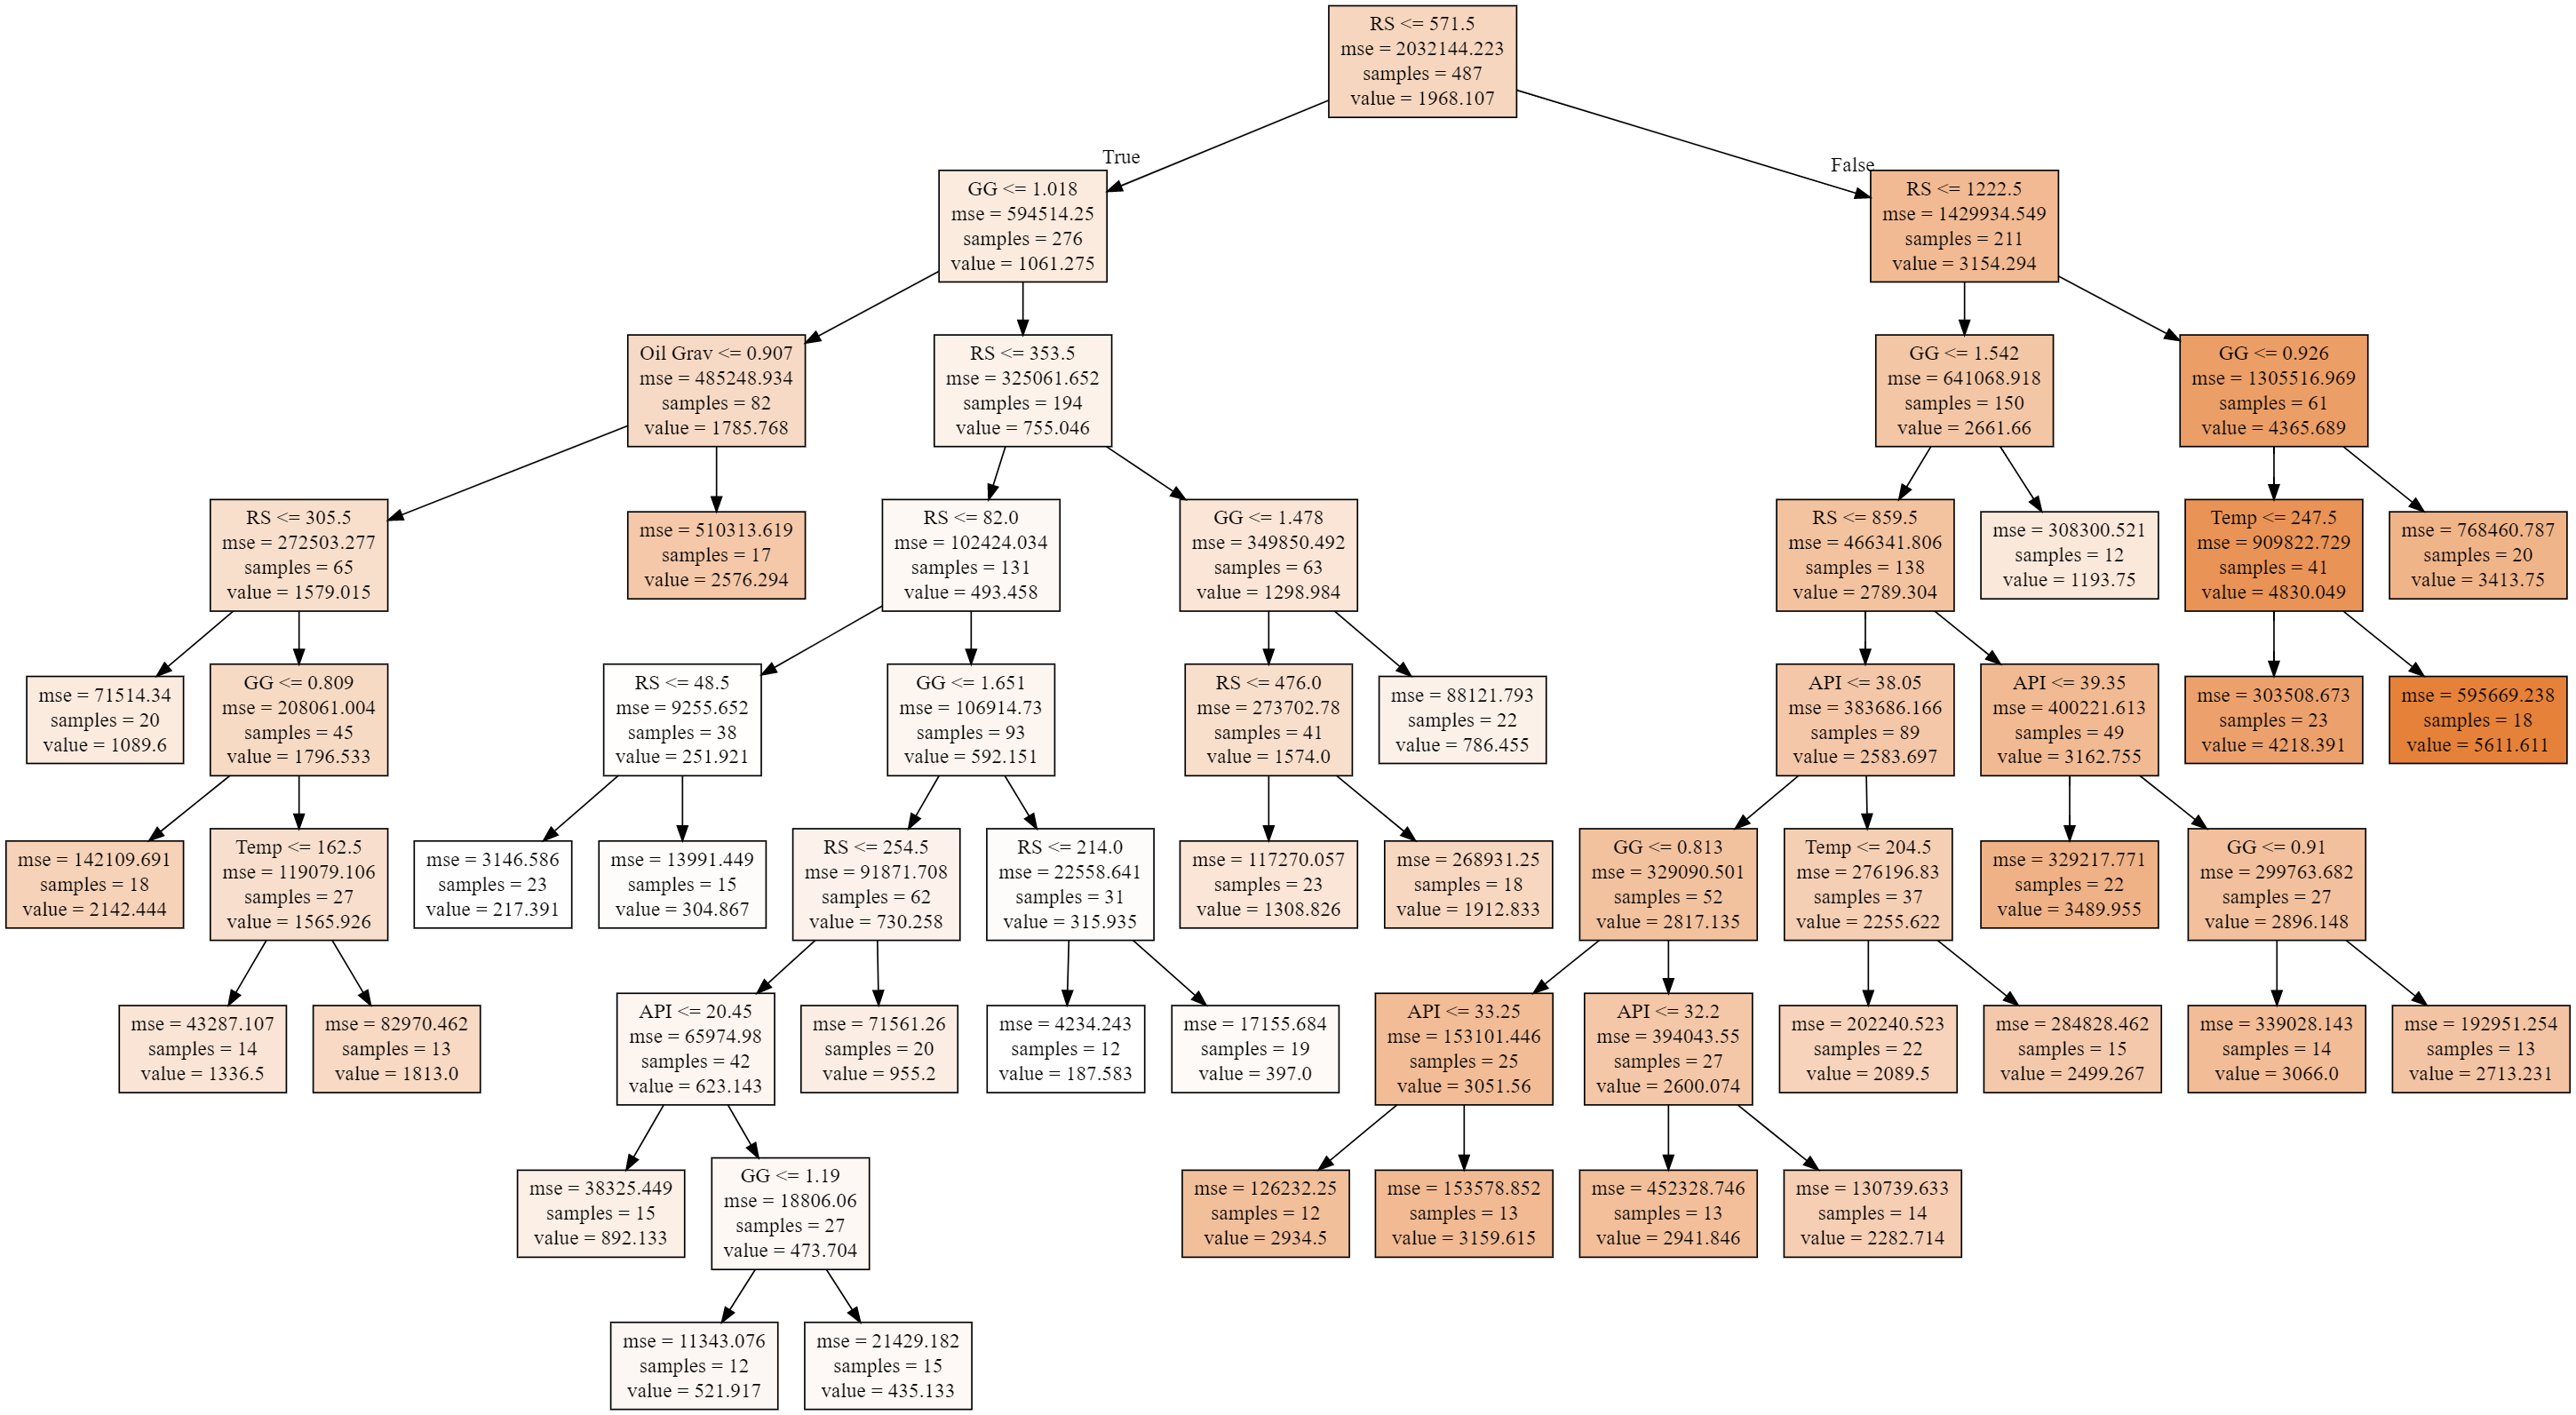

### Random Forest

In [22]:
rf = RandomForestRegressor()

display(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [23]:
max_depth = list(np.arange(2,21,2))
n_estimators =  list(np.arange(2,30,2))
min_samples_leaf = list(np.arange(2,15,2))

      
# Defining params_dt   
params_rf = {'max_depth': max_depth, 'min_samples_leaf':min_samples_leaf,'n_estimators': n_estimators}
#'max_features': ['log2', 'auto', 'sqrt']

# Instantiate grid_dt
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring='r2',
                       cv=10,
                       n_jobs=-1)

#or scoring='roc_auc'

grid_rf.fit(X_train_data, y_train)

best_model_RF = grid_rf.best_estimator_

print(f'Best Paramns: {grid_rf.best_params_}')

#Saving the model
filename = 'RadomForest_model.sav'
pickle.dump(best_model_RF, open(filename, 'wb'))

#for load
#loaded_best_model = pickle.load(open(filename, 'rb'))
#result = loaded_best_model.score(X_test, Y_test)
#print(result)

Best Paramns: {'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 16}


C:\Users\danie\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [24]:
Treinamento = best_model_RF.predict(X_train_data)
Resultado = best_model_RF.predict(X_test_data)

R2_treinamento = round(r2_score(y_train, Treinamento),4)
R2_test = round(r2_score(y_test, Resultado),4)

print(f' R2_Train = {R2_treinamento}')
print(f' R2_test = {R2_test}')    

Error_Results = pd.concat([Error_Results, statistcs(y_test, Resultado)])

display(Error_Results)

 R2_Train = 0.9801
 R2_test = 0.9102


,MAE,MAPE_(%),RMSE,SDa,SDr,Emax,R2
Standing,320.36,24.31,566.04,467.63,1.46,3549.07,0.8511
Vasquez-Beggs,373.12,28.19,655.57,540.16,1.45,4230.90,0.8002
Glaso,405.17,25.72,608.28,454.64,1.12,3580.01,0.8280
Al-Marhoun,426.71,21.68,734.84,599.50,1.40,4943.84,0.7490
Petroski-Farshad,559.36,78.19,734.31,476.73,0.85,4151.92,0.7494
0,367.46,27.87,576.54,445.19,1.21,4130.56,0.8455
0,252.02,17.16,439.55,360.88,1.43,4035.73,0.9102


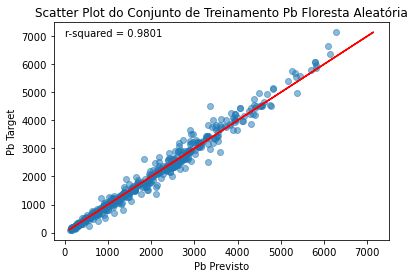

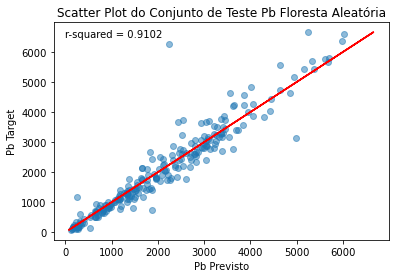

In [25]:
plt.scatter(Treinamento, y_train, alpha=0.5)
plt.plot(y_train, y_train, color = 'red')
plt.title('Scatter Plot do Conjunto de Treinamento Pb Floresta Aleatória')
plt.ylabel('Pb Target')
plt.xlabel('Pb Previsto')
plt.annotate(f'r-squared = {R2_treinamento}', (0,7000))
plt.show()

plt.scatter(Resultado, y_test, alpha=0.5)
plt.plot(y_test,y_test, color = 'red')
plt.title('Scatter Plot do Conjunto de Teste Pb Floresta Aleatória')
plt.ylabel('Pb Target')
plt.xlabel('Pb Previsto')
plt.annotate(f'r-squared = {R2_test}', (0,6500))
plt.show()

## SVR

### Tunning By GRID SEARCH

In [26]:
C = [0.001, 0.01, 0.1, 1.0, 10]
gamma = [0.01,0.317,10.0, 317, 10000]
epsilon =[0.01, 0.0317, 0.1, 0.317, 1.0]

svr = SVR()

display(svr.get_params())

# Defining params_dt   
params_svr = {'C': C, 'gamma':gamma,'epsilon': epsilon}
#'max_features': ['log2', 'auto', 'sqrt']

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [27]:
df_norm = minmax_scale(df.iloc[:,0:6])

X_norm = pd.DataFrame(df_norm[:,1:6], columns = ['RS', 'GG', 'API', 'TEMP', 'OilGrav'] )
X_norm = X_norm.drop(['API'], axis = 1)
#X_norm = X_norm.drop(['OilGrav'], axis = 1)

y_norm = df_norm[:,0]

X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y_norm, test_size=0.33, random_state=0)

X_train_data_norm, X_test_data_norm = X_train_norm.iloc[:,0:5], X_test_norm.iloc[:,0:5]

In [28]:
grid_SVR = GridSearchCV(estimator=svr,
                       param_grid=params_svr,
                       scoring='r2',
                       cv=10,
                       n_jobs=-1)

grid_SVR.fit(X_train_data_norm, y_train_norm)

best_model_svr = grid_SVR.best_estimator_

print(f'Best Paramns: {grid_SVR.best_params_}')

#Saving the model
filename = 'SVR_model.sav'
pickle.dump(best_model_svr, open(filename, 'wb'))

#for load
#loaded_best_model = pickle.load(open(filename, 'rb'))
#result = loaded_best_model.score(X_test, Y_test)
#print(result)

Best Paramns: {'C': 1.0, 'epsilon': 0.01, 'gamma': 10.0}


In [29]:
#Desnomalization 
dfminmax

min_PB = 79
max_PB = 7142

Treinamento = best_model_svr.predict(X_train_data_norm)
Resultado = best_model_svr.predict(X_test_data_norm)

Treinamento = Treinamento * (max_PB - min_PB) + min_PB
Resultado = Resultado * (max_PB - min_PB) + min_PB

 R2_Train = 0.966
 R2_test = 0.9497


,MAE,MAPE_(%),RMSE,SDa,SDr,Emax,R2
Standing,320.36,24.31,566.04,467.63,1.46,3549.07,0.8511
Vasquez-Beggs,373.12,28.19,655.57,540.16,1.45,4230.90,0.8002
Glaso,405.17,25.72,608.28,454.64,1.12,3580.01,0.8280
Al-Marhoun,426.71,21.68,734.84,599.50,1.40,4943.84,0.7490
Petroski-Farshad,559.36,78.19,734.31,476.73,0.85,4151.92,0.7494
0,367.46,27.87,576.54,445.19,1.21,4130.56,0.8455
0,252.02,17.16,439.55,360.88,1.43,4035.73,0.9102
0,183.04,13.69,329.13,274.11,1.50,2996.13,0.9497


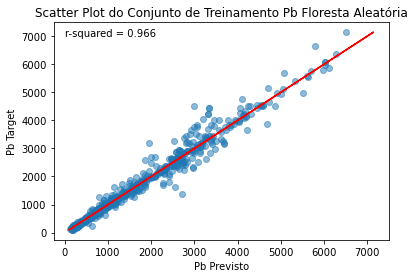

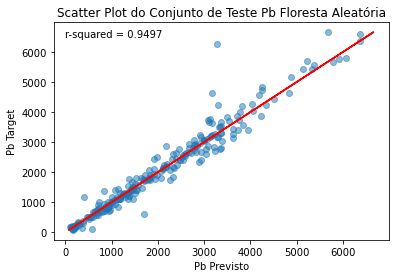

In [30]:
R2_treinamento = round(r2_score(y_train, Treinamento),4)
R2_test = round(r2_score(y_test, Resultado),4)

print(f' R2_Train = {R2_treinamento}')
print(f' R2_test = {R2_test}')    

Error_Results = pd.concat([Error_Results, statistcs(y_test, Resultado)])

display(Error_Results)

plt.scatter(Treinamento, y_train, alpha=0.5)
plt.plot(y_train, y_train, color = 'red')
plt.title('Scatter Plot do Conjunto de Treinamento Pb Floresta Aleatória')
plt.ylabel('Pb Target')
plt.xlabel('Pb Previsto')
plt.annotate(f'r-squared = {R2_treinamento}', (0,7000))
plt.show()

plt.scatter(Resultado, y_test, alpha=0.5)
plt.plot(y_test,y_test, color = 'red')
plt.title('Scatter Plot do Conjunto de Teste Pb Floresta Aleatória')
plt.ylabel('Pb Target')
plt.xlabel('Pb Previsto')
plt.annotate(f'r-squared = {R2_test}', (0,6500))
plt.show()

# ANN

*FURTUNA, R., CURTEANU, S. e CAZACU, M., Optimization methodology applied to feed-forward artificial neural network parameters. International Journal of Quantum Chemistry, v. 111, n. 3, p. 539–553, Iasi, Romênia, dezembro, 2009*

This Article reports the optimization methodology, this means, how to tune hyperparameters of our neral Network. 

To optimize network performance, a series of neural network parameters such as **number of hidden layers, number of neurons in
the hidden layers, learning rate, momentum term, and activation function of the output layer** were elected after series of simulations in which there were varied all these parameters, while choosing a optimum **number of training epochs**.

The role of the hidden layers is to **detect relationships between network inputs and outputs**.

The most important problem is to find the **minimum number of hidden layers** that can create adequately complex decision boundaries, also reducing the computational time needed for training. For many applications, the optimum number of hidden layers has been found to be less than the number of inputs.

The optimum number of training epochs has to be determined through cross-validation, a highly recommended method for stopping network training. The training set is divided in around 80% data for training and the rest are data for cross-validation. 

Training and testing are done in the same time and the training is stopped when the mean squared error for the cross-validation data set starts to rise. This moment is called point of maximum generalization. Depending on the network performance at this time, different configurations can then be tried, decreasing or increasing the number of neurons in the hidden layer(s)

### Neural Network Hyperpramaeters

- Number of Layers | **Used**
- number os Neurons per Layer | **Used [2, 4, 6, 8, ... ,30]**
- Layer Order 
- Layer Activations | **Used ['sigmoid', 'tanh', 'relu']**
- Batch Sizes |** Used 64**
- Learning Rates | **Used 0.1**
- Optimizer | **Used Adam**

In [31]:
Nin = X_train_data_norm.shape[1]
Nout = 1
#Nhidden = 23

R2melhor = 0
report = []

activation_function = ['sigmoid', 'tanh', 'relu']
iteration = 0

for Nhidden in range(1,31,2):
    
    for hidden_activation in activation_function:
        
        for output_activation in activation_function:
            
            iteration += 1
            print(f'########### Iter {iteration} NHidden {Nhidden} ###########')
            print(f'hidden_activation {hidden_activation} output_activation {output_activation}')

            input_ = keras.layers.Input(shape=(Nin,))
            hidden = keras.layers.Dense(Nhidden, activation=hidden_activation)(input_)
            output = keras.layers.Dense(Nout, activation=output_activation)(hidden)

            # instantiate model
            model = keras.models.Model(inputs=[input_],outputs=[output])

            # define optimizer and learning rate
            optimizer = keras.optimizers.SGD(learning_rate = 0.1)

            # compile model to train it
            model.compile(loss="mean_squared_error", optimizer=optimizer)

            #history = model.fit(X_train_norm,y_train_norm, epochs=500, batch_size = 64)
            
            # Define early_stopping_monitor
            early_stopping_monitor = EarlyStopping(patience = 5)

            # Fit the model
            history = model.fit(X_train_data_norm,y_train_norm, 
                    validation_split=0.1, verbose = 0,
                    epochs = 200, batch_size = 64,
                    callbacks = [early_stopping_monitor])
            
            results_ANN = model.predict(X_test_data_norm)
            
            results_ANN = results_ANN * (max_PB - min_PB) + min_PB
    
            R2_test = round(r2_score(y_test, results_ANN),5)
        
            report.append([iteration, Nhidden,hidden_activation, output_activation, R2_test])
    
            if R2_test > R2melhor:
                R2melhor = R2_test
                Best_Tunning = [iteration, Nhidden, hidden_activation, output_activation, R2_test]
                display(Best_Tunning)

Report = pd.DataFrame(report, columns =['iteration', 'Neurons_in_Hidden','hidden_activation', 'output_activation', 'R2_test'] )

display(Report)
display(Best_Tunning)

########### Iter 1 NHidden 1 ###########
hidden_activation sigmoid output_activation sigmoid
########### Iter 2 NHidden 1 ###########
hidden_activation sigmoid output_activation tanh


[2, 1, 'sigmoid', 'tanh', 0.7197]

########### Iter 3 NHidden 1 ###########
hidden_activation sigmoid output_activation relu
########### Iter 4 NHidden 1 ###########
hidden_activation tanh output_activation sigmoid


[4, 1, 'tanh', 'sigmoid', 0.72585]

########### Iter 5 NHidden 1 ###########
hidden_activation tanh output_activation tanh


[5, 1, 'tanh', 'tanh', 0.82013]

########### Iter 6 NHidden 1 ###########
hidden_activation tanh output_activation relu


[6, 1, 'tanh', 'relu', 0.87645]

########### Iter 7 NHidden 1 ###########
hidden_activation relu output_activation sigmoid
########### Iter 8 NHidden 1 ###########
hidden_activation relu output_activation tanh
########### Iter 9 NHidden 1 ###########
hidden_activation relu output_activation relu
########### Iter 10 NHidden 3 ###########
hidden_activation sigmoid output_activation sigmoid
########### Iter 11 NHidden 3 ###########
hidden_activation sigmoid output_activation tanh
########### Iter 12 NHidden 3 ###########
hidden_activation sigmoid output_activation relu
########### Iter 13 NHidden 3 ###########
hidden_activation tanh output_activation sigmoid
########### Iter 14 NHidden 3 ###########
hidden_activation tanh output_activation tanh
########### Iter 15 NHidden 3 ###########
hidden_activation tanh output_activation relu
########### Iter 16 NHidden 3 ###########
hidden_activation relu output_activation sigmoid
########### Iter 17 NHidden 3 ###########
hidden_activation relu output_activation tanh
########### It

[27, 5, 'relu', 'relu', 0.87873]

########### Iter 28 NHidden 7 ###########
hidden_activation sigmoid output_activation sigmoid
########### Iter 29 NHidden 7 ###########
hidden_activation sigmoid output_activation tanh
########### Iter 30 NHidden 7 ###########
hidden_activation sigmoid output_activation relu
########### Iter 31 NHidden 7 ###########
hidden_activation tanh output_activation sigmoid
########### Iter 32 NHidden 7 ###########
hidden_activation tanh output_activation tanh
########### Iter 33 NHidden 7 ###########
hidden_activation tanh output_activation relu


[33, 7, 'tanh', 'relu', 0.87878]

########### Iter 34 NHidden 7 ###########
hidden_activation relu output_activation sigmoid
########### Iter 35 NHidden 7 ###########
hidden_activation relu output_activation tanh
########### Iter 36 NHidden 7 ###########
hidden_activation relu output_activation relu


[36, 7, 'relu', 'relu', 0.87977]

########### Iter 37 NHidden 9 ###########
hidden_activation sigmoid output_activation sigmoid
########### Iter 38 NHidden 9 ###########
hidden_activation sigmoid output_activation tanh
########### Iter 39 NHidden 9 ###########
hidden_activation sigmoid output_activation relu
########### Iter 40 NHidden 9 ###########
hidden_activation tanh output_activation sigmoid
########### Iter 41 NHidden 9 ###########
hidden_activation tanh output_activation tanh
########### Iter 42 NHidden 9 ###########
hidden_activation tanh output_activation relu
########### Iter 43 NHidden 9 ###########
hidden_activation relu output_activation sigmoid
########### Iter 44 NHidden 9 ###########
hidden_activation relu output_activation tanh
########### Iter 45 NHidden 9 ###########
hidden_activation relu output_activation relu
########### Iter 46 NHidden 11 ###########
hidden_activation sigmoid output_activation sigmoid
########### Iter 47 NHidden 11 ###########
hidden_activation sigmoid output_activation tanh
###

[72, 15, 'relu', 'relu', 0.88687]

########### Iter 73 NHidden 17 ###########
hidden_activation sigmoid output_activation sigmoid
########### Iter 74 NHidden 17 ###########
hidden_activation sigmoid output_activation tanh
########### Iter 75 NHidden 17 ###########
hidden_activation sigmoid output_activation relu
########### Iter 76 NHidden 17 ###########
hidden_activation tanh output_activation sigmoid
########### Iter 77 NHidden 17 ###########
hidden_activation tanh output_activation tanh
########### Iter 78 NHidden 17 ###########
hidden_activation tanh output_activation relu
########### Iter 79 NHidden 17 ###########
hidden_activation relu output_activation sigmoid
########### Iter 80 NHidden 17 ###########
hidden_activation relu output_activation tanh
########### Iter 81 NHidden 17 ###########
hidden_activation relu output_activation relu
########### Iter 82 NHidden 19 ###########
hidden_activation sigmoid output_activation sigmoid
########### Iter 83 NHidden 19 ###########
hidden_activation sigmoid output_activation

[99, 21, 'relu', 'relu', 0.88931]

########### Iter 100 NHidden 23 ###########
hidden_activation sigmoid output_activation sigmoid
########### Iter 101 NHidden 23 ###########
hidden_activation sigmoid output_activation tanh
########### Iter 102 NHidden 23 ###########
hidden_activation sigmoid output_activation relu
########### Iter 103 NHidden 23 ###########
hidden_activation tanh output_activation sigmoid
########### Iter 104 NHidden 23 ###########
hidden_activation tanh output_activation tanh
########### Iter 105 NHidden 23 ###########
hidden_activation tanh output_activation relu
########### Iter 106 NHidden 23 ###########
hidden_activation relu output_activation sigmoid
########### Iter 107 NHidden 23 ###########
hidden_activation relu output_activation tanh
########### Iter 108 NHidden 23 ###########
hidden_activation relu output_activation relu
########### Iter 109 NHidden 25 ###########
hidden_activation sigmoid output_activation sigmoid
########### Iter 110 NHidden 25 ###########
hidden_activation sigmoid output

,iteration,Neurons_in_Hidden,hidden_activation,output_activation,R2_test
0,1,1,sigmoid,sigmoid,-0.00109
1,2,1,sigmoid,tanh,0.71970
2,3,1,sigmoid,relu,-0.10497
3,4,1,tanh,sigmoid,0.72585
4,5,1,tanh,tanh,0.82013
...,...,...,...,...,...
130,131,29,tanh,tanh,0.83928
131,132,29,tanh,relu,0.87461
132,133,29,relu,sigmoid,0.81002
133,134,29,relu,tanh,0.82779


[99, 21, 'relu', 'relu', 0.88931]

In [32]:
filtro = Report.R2_test >= 0.88

Report.loc[filtro].sort_values('R2_test', ascending = False)

,iteration,Neurons_in_Hidden,hidden_activation,output_activation,R2_test
98,99,21,relu,relu,0.88931
71,72,15,relu,relu,0.88687
116,117,25,relu,relu,0.88127


In [33]:
print(Best_Tunning)

[99, 21, 'relu', 'relu', 0.88931]


In [34]:
print(type(Resultado),type(Treinamento))

print(Resultado.shape,Treinamento.shape)

Resultado = Resultado.reshape(-1,)

print(Resultado.shape,Treinamento.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(240,) (487,)
(240,) (487,)


In [35]:
input_ = keras.layers.Input(shape=(Nin,))

hidden = keras.layers.Dense(Best_Tunning[1], activation=Best_Tunning[2])(input_)
output = keras.layers.Dense(Nout, activation=Best_Tunning[3])(hidden)

model.summary()

# instantiate model
model = keras.models.Model(inputs=[input_],outputs=[output])

# define optimizer and learning rate
optimizer = keras.optimizers.SGD(learning_rate = 0.1)

# compile model to train it
model.compile(loss="mean_squared_error", optimizer=optimizer)

early_stopping_monitor = EarlyStopping(patience = 5)

# Fit the model
history = model.fit(X_train_data_norm,y_train_norm, 
                    validation_split=0.1,
                    epochs = 200, batch_size = 64,
                    callbacks = [early_stopping_monitor])

#history = model.fit(X_train_norm,y_train_norm, epochs=200, batch_size = 50)

results_ANN = model.predict(X_test_data_norm)           
Resultado = results_ANN * (max_PB - min_PB) + min_PB  

Treinamento = model.predict(X_train_data_norm)
Treinamento = Treinamento * (max_PB - min_PB) + min_PB  

Resultado = Resultado.reshape(-1,)
Treinamento = Treinamento.reshape(-1,)

Model: "model_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_135 (InputLayer)      [(None, 4)]               0         
                                                                 
 dense_268 (Dense)           (None, 29)                145       
                                                                 
 dense_269 (Dense)           (None, 1)                 30        
                                                                 
Total params: 175
Trainable params: 175
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0664 - val_loss: 0.0273
Epoch 2/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0277 - val_loss: 0.0259
Epoch 3/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0244 - val_loss: 0.0214
Epoch 4/200
7/7 [==============

In [36]:
model.save('Neural_Network_model.h5')
model.save('Neural_Network_model')
#To load
#my_model = load_model('Neural_Network_model.h5')
#predictions = my_model.predict(data_to_predict_with)

INFO:tensorflow:Assets written to: Neural_Network_model\assets


In [37]:
MAE = round(mean_absolute_error(y_test, Resultado),2)
MAPE_var = round(MAPE(y_test, Resultado)*100,2)
RMSE = round(mean_squared_error(y_test, Resultado)**0.5,2)
MAX_ERROR = round(max_error(y_test, Resultado),2)
R2_test = round(r2_score(y_test, Resultado),4)

prediction_error = abs(np.array(y_test).flatten() - Resultado.flatten())
Stdev_abs = round(st.stdev(prediction_error),2)
Stdev_rel = round(st.stdev(prediction_error/st.mean(prediction_error)),2)

Error_ANN = [MAE, MAPE_var, RMSE, Stdev_abs, Stdev_rel,MAX_ERROR,R2_test]
Error_ANN = pd.DataFrame([Error_ANN], columns = ['MAE','MAPE_(%)','RMSE','SDa', 'SDr','Emax','R2'])

Error_Results = pd.concat([Error_Results, Error_ANN])
display(Error_Results)

,MAE,MAPE_(%),RMSE,SDa,SDr,Emax,R2
Standing,320.36,24.31,566.04,467.63,1.46,3549.07,0.8511
Vasquez-Beggs,373.12,28.19,655.57,540.16,1.45,4230.90,0.8002
Glaso,405.17,25.72,608.28,454.64,1.12,3580.01,0.8280
Al-Marhoun,426.71,21.68,734.84,599.50,1.40,4943.84,0.7490
Petroski-Farshad,559.36,78.19,734.31,476.73,0.85,4151.92,0.7494
0,367.46,27.87,576.54,445.19,1.21,4130.56,0.8455
0,252.02,17.16,439.55,360.88,1.43,4035.73,0.9102
0,183.04,13.69,329.13,274.11,1.50,2996.13,0.9497
0,428.02,31.85,566.20,371.42,0.87,3411.15,0.8510


 R2_Train = 0.8456
 R2_test = 0.851


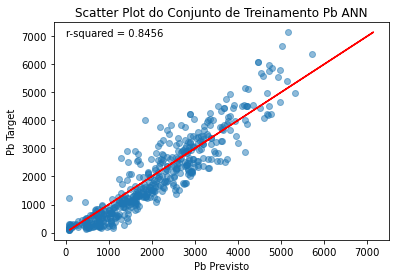

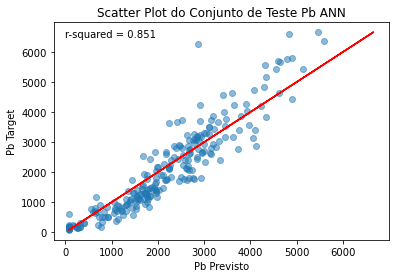

In [38]:
R2_treinamento = round(r2_score(y_train, Treinamento),4)
R2_test = round(r2_score(y_test, Resultado),4)

print(f' R2_Train = {R2_treinamento}')
print(f' R2_test = {R2_test}')    

plt.scatter(Treinamento, y_train, alpha=0.5)
plt.plot(y_train, y_train, color = 'red')
plt.title('Scatter Plot do Conjunto de Treinamento Pb ANN')
plt.ylabel('Pb Target')
plt.xlabel('Pb Previsto')
plt.annotate(f'r-squared = {R2_treinamento}', (0,7000))
plt.show()

plt.scatter(Resultado, y_test, alpha=0.5)
plt.plot(y_test,y_test, color = 'red')
plt.title('Scatter Plot do Conjunto de Teste Pb ANN')
plt.ylabel('Pb Target')
plt.xlabel('Pb Previsto')
plt.annotate(f'r-squared = {R2_test}', (0,6500))
plt.show()

# RESULTADOS

Os comparativos entre os modelos de previsão obtidos e as correlações empíricas foram realizados mediante análise estatística de erros do conjunto de dados destinado aos testes, utilizando a metodologia proposta por Ikiensikimama e Azubuike, 2012, o qual ranqueia os modelos pelo somatório de pesos atribuídos a diferentes avaliadores estatíticos.

A escolha de tais pesos foi realizada de forma a integrar tanto o grau de acurácia do modelo justificado pela análise dos erros relativos e absolutos. quanto a dispersão dos erros de predição dos modelos gerados, considerando a análise dos desvios padrões e coeficiente de correlação.


**IKIENSIKIMAMA, S. S. e AZUBUIKE, I. I.**, *Modeling Approach for Niger-Delta Oil Formation Volume Factor Prediction Using Artificial Neural Network*, In: CONFERÊNCIA E EXPOSIÇÃO ANUAL INTERNACIONAL DA NIGÉRIA, Abuja, Nigeria, Agosto, 2012.

In [39]:
Error_Results_index = ['Standing', 'Vasquez-Beggs', 'Glaso', 'Al-Marhoun', 'Petroski-Farshad',
                       'Decision Tree', 'Random Forest', 'SVR', 'NN']
    
Error_Results.index = Error_Results_index
display(Error_Results)

Error_Results.to_csv('Statistical_results.csv')

,MAE,MAPE_(%),RMSE,SDa,SDr,Emax,R2
Standing,320.36,24.31,566.04,467.63,1.46,3549.07,0.8511
Vasquez-Beggs,373.12,28.19,655.57,540.16,1.45,4230.90,0.8002
Glaso,405.17,25.72,608.28,454.64,1.12,3580.01,0.8280
Al-Marhoun,426.71,21.68,734.84,599.50,1.40,4943.84,0.7490
Petroski-Farshad,559.36,78.19,734.31,476.73,0.85,4151.92,0.7494
Decision Tree,367.46,27.87,576.54,445.19,1.21,4130.56,0.8455
Random Forest,252.02,17.16,439.55,360.88,1.43,4035.73,0.9102
SVR,183.04,13.69,329.13,274.11,1.50,2996.13,0.9497
NN,428.02,31.85,566.20,371.42,0.87,3411.15,0.8510


In [40]:
Weigths_avaliator = [0.2, 0.4, 0.2, 0.1, 0.15, 0, 0.2]
index = 0

Error_Results_copy = Error_Results.copy()

Error_Results_copy['Results'] = 0

for column in Error_Results.columns:
    
    #Normalização dos valores
    Error_Results_copy[column] = (Error_Results_copy[column]-Error_Results[column].min())/(Error_Results[column].max()-Error_Results[column].min())
   
    if column == 'R2':        
        Error_Results_copy['Results'] = Error_Results_copy['Results'] + (1-Error_Results_copy[column])*Weigths_avaliator[index]
    else:
        Error_Results_copy['Results'] = Error_Results_copy['Results'] + Error_Results_copy[column]*Weigths_avaliator[index]
    index += 1
    

Error_Results['Results'] = Error_Results_copy['Results']

display(Error_Results)

,MAE,MAPE_(%),RMSE,SDa,SDr,Emax,R2,Results
Standing,320.36,24.31,566.04,467.63,1.46,3549.07,0.8511,0.554127
Vasquez-Beggs,373.12,28.19,655.57,540.16,1.45,4230.90,0.8002,0.721069
Glaso,405.17,25.72,608.28,454.64,1.12,3580.01,0.8280,0.569333
Al-Marhoun,426.71,21.68,734.84,599.50,1.40,4943.84,0.7490,0.805975
Petroski-Farshad,559.36,78.19,734.31,476.73,0.85,4151.92,0.7494,1.061610
Decision Tree,367.46,27.87,576.54,445.19,1.21,4130.56,0.8455,0.547405
Random Forest,252.02,17.16,439.55,360.88,1.43,4035.73,0.9102,0.312487
SVR,183.04,13.69,329.13,274.11,1.50,2996.13,0.9497,0.150000
NN,428.02,31.85,566.20,371.42,0.87,3411.15,0.8510,0.492561
